# Import Libraries

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [7]:
str_sed_data = pd.read_csv(data_path + '/new_stream_sediments_57F11_1.csv')

In [8]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,yb,lu,hf,ta,w,u,toposheet,hg,cd,cluster
0,2947,2947,57F11/177/SS/12,77.657407,14.475225,61.921,14.606,4.51,0.05,2.28,...,2.290226,0.413697,26.874492,0.677483,2.5,3.016905,57F11,8.0,50,2
1,2948,2948,57F11/178/SS/12,77.675926,14.475225,62.077,13.750,4.22,0.05,2.43,...,2.891123,0.500104,37.079419,0.774466,2.5,3.378550,57F11,9.0,50,2
2,2949,2949,57F11/179/SS/12,77.694444,14.475225,68.645,13.410,3.02,0.05,1.32,...,2.323000,0.423000,23.652000,0.715000,2.5,3.509000,57F11,2.5,50,1
3,2950,2950,57F11/180/SS/12,77.712963,14.475225,64.950,14.280,3.46,0.05,1.75,...,2.186000,0.400000,21.961000,0.744000,2.5,4.241000,57F11,19.0,50,1
4,2951,2951,57F11/181/SS/12,77.731481,14.475225,64.302,14.010,4.08,0.05,1.84,...,2.322000,0.431000,26.705000,0.832000,2.5,4.218000,57F11,19.0,50,2


# EDA

In [18]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

str_elem_df = str_sed_data[str_elem]

In [19]:
str_elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,tm,yb,lu,hf,ta,w,u,hg,cd,cluster
0,61.921,14.606,4.51,0.05,2.28,3.24,1.52,2.46,0.61,0.13,...,0.359742,2.290226,0.413697,26.874492,0.677483,2.5,3.016905,8.0,50,2
1,62.077,13.750,4.22,0.05,2.43,4.14,1.52,2.55,0.64,0.12,...,0.419132,2.891123,0.500104,37.079419,0.774466,2.5,3.378550,9.0,50,2
2,68.645,13.410,3.02,0.05,1.32,3.19,2.89,3.08,0.75,0.08,...,0.329000,2.323000,0.423000,23.652000,0.715000,2.5,3.509000,2.5,50,1
3,64.950,14.280,3.46,0.05,1.75,3.10,2.34,2.82,0.60,0.12,...,0.306000,2.186000,0.400000,21.961000,0.744000,2.5,4.241000,19.0,50,1
4,64.302,14.010,4.08,0.05,1.84,3.24,2.12,2.83,0.75,0.16,...,0.334000,2.322000,0.431000,26.705000,0.832000,2.5,4.218000,19.0,50,2


## Concentration of elements in each cluster

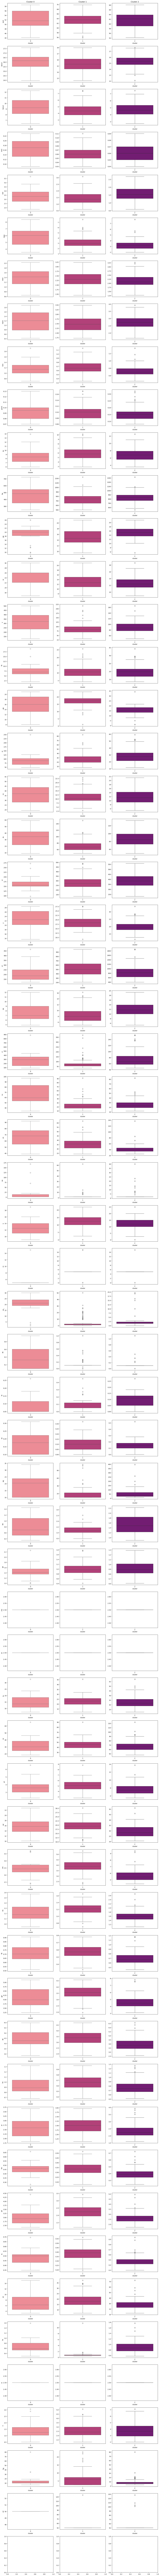

In [20]:
n_elem = len(str_elem_df.columns)
n_clstr = len(str_elem_df['cluster'].unique())
col_pal = ['#FC7C89', '#C52E79', '#800F80']

fig, axes = plt.subplots(nrows=n_elem, 
                         ncols=n_clstr, 
                         figsize=(15, 4 * n_elem))

# If only one row or one column, axes need to be reshaped into a 2D array for consistency in indexing
if n_elem == 1:
    axes = np.expand_dims(axes, 
                          axis=0)
if n_clstr == 1:
    axes = np.expand_dims(axes, 
                          axis=1)

# Loop through each element
for i, element in enumerate(str_elem_df.columns[:-1]):  # assuming the last column is 'cluster'
    for cluster in range(n_clstr):
        # Filter data for the current cluster
        cluster_data = str_elem_df[str_elem_df['cluster'] == cluster]
        
        # Create boxplot for the current element in the current cluster subplot
        sns.boxplot(x='cluster', 
                    y=element, 
                    data=cluster_data, 
                    ax=axes[i, cluster], 
                    palette=[col_pal[cluster]])
        
        # Set titles and labels appropriately
        if i == 0:
            axes[i, cluster].set_title(f'Cluster {cluster}')
        if cluster == 0:
            axes[i, cluster].set_ylabel(element)
        else:
            axes[i, cluster].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

## Heatmap for dominant elements among clusters

In [28]:
cluster_mean = str_elem_df.groupby('cluster')[str_elem].mean()
cluster_mean.drop(['cluster'], axis=1, inplace=True)

In [29]:
cluster_mean

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,er,tm,yb,lu,hf,ta,w,u,hg,cd
cluster,,,,,,,,,,,,,,,,,,,,,
0,52.110818,15.963409,9.451364,0.167273,3.355909,5.805000,1.386818,1.150455,1.184545,0.095000,...,2.596489,0.456448,3.014570,0.484235,7.098007,0.670740,2.5,1.495547,16.772727,50.000000
1,63.374743,15.293648,4.474028,0.061389,1.448704,3.195741,2.316759,2.468519,0.683889,0.100648,...,2.013041,0.339604,2.257229,0.384794,18.640085,0.853549,2.5,2.551685,6.356481,50.685185
2,61.771219,15.230644,4.734178,0.061233,1.603973,3.287534,2.139452,2.737260,0.730548,0.156712,...,2.364531,0.398426,2.682433,0.474346,28.702119,0.910390,2.5,3.834558,9.198630,53.315068


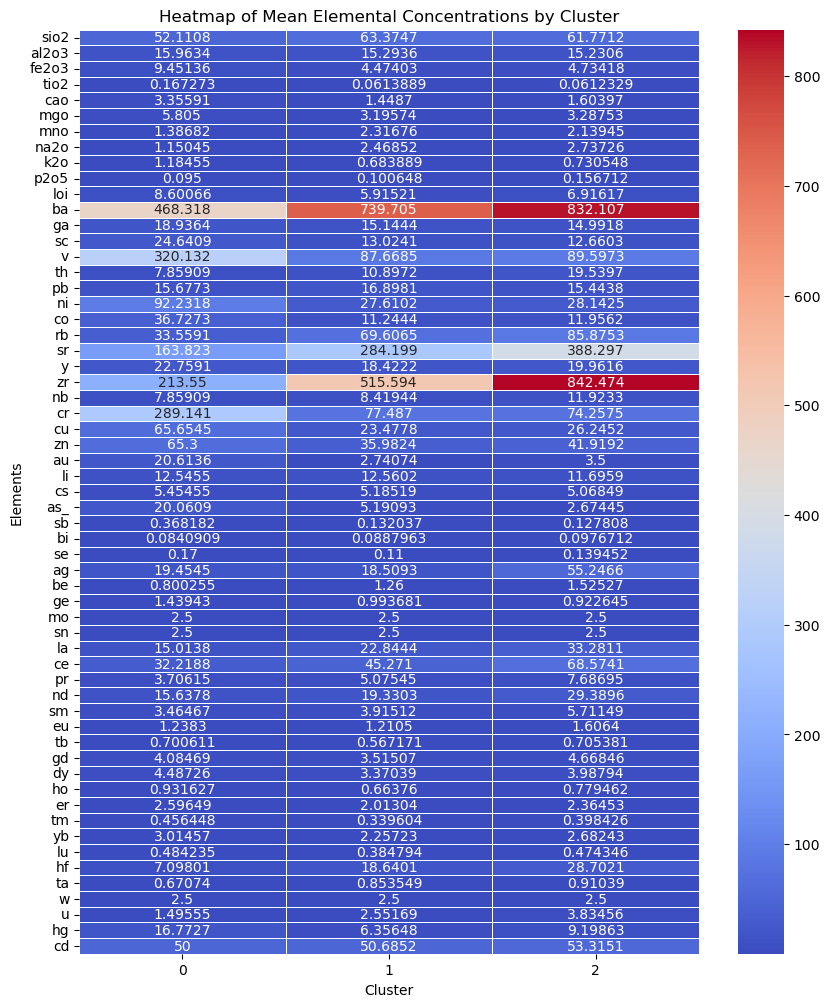

In [37]:
plt.figure(figsize=(10, 12))
heatmap = sns.heatmap(cluster_mean.T, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=.5, 
                      fmt='g')
heatmap.set_title('Heatmap of Mean Elemental Concentrations by Cluster')
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Elements')
plt.show()

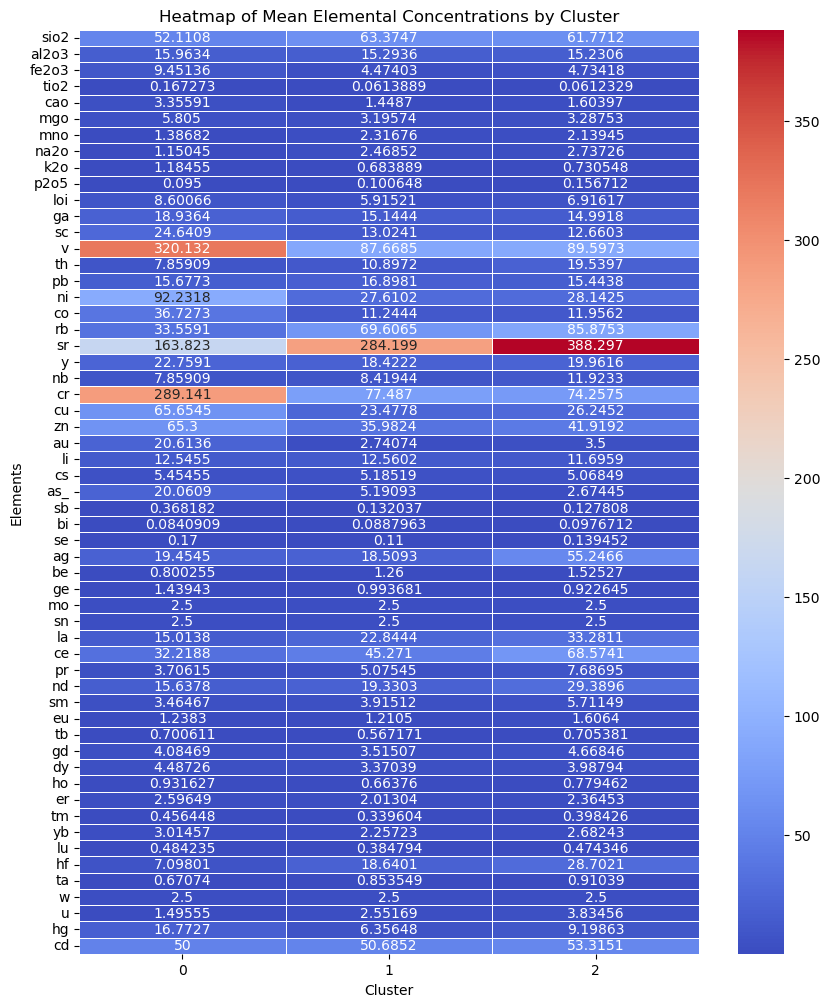

In [38]:
plt.figure(figsize=(10, 12))
heatmap = sns.heatmap(cluster_mean1.T, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=.5, 
                      fmt='g')
heatmap.set_title('Heatmap of Mean Elemental Concentrations by Cluster')
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Elements')
plt.show()

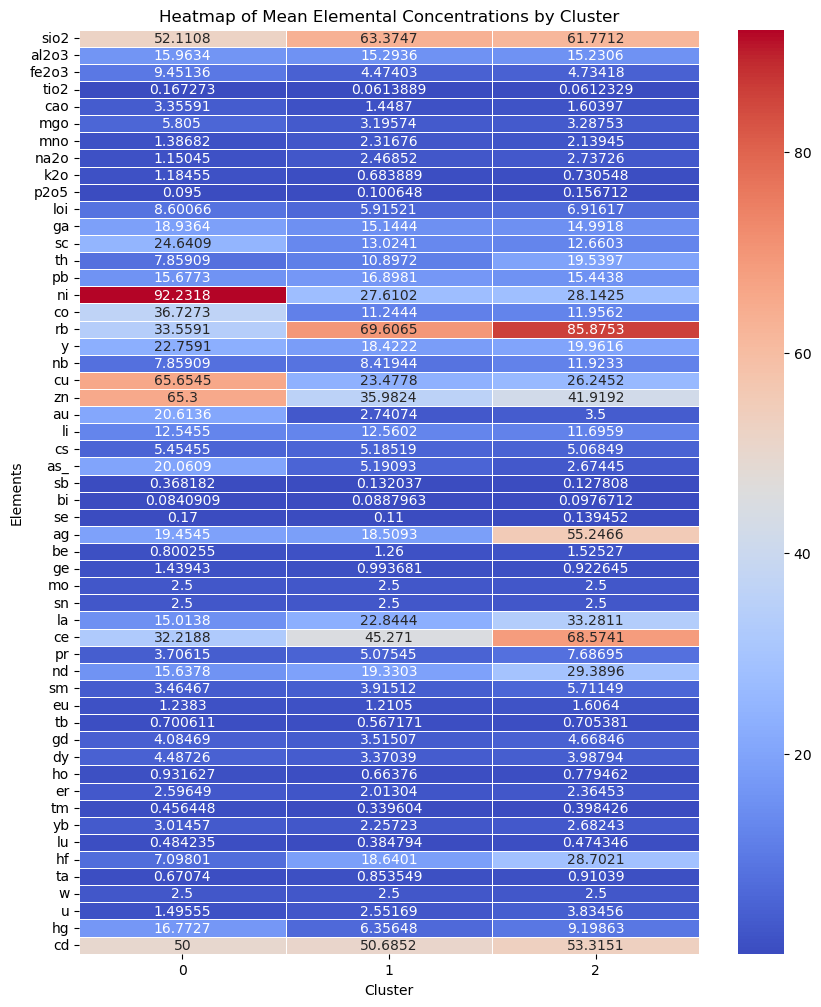

In [40]:
plt.figure(figsize=(10, 12))
heatmap = sns.heatmap(cluster_mean2.T, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=.5, 
                      fmt='g')
heatmap.set_title('Heatmap of Mean Elemental Concentrations by Cluster')
heatmap.set_xlabel('Cluster')
heatmap.set_ylabel('Elements')
plt.show()

In [62]:
elem_clstr_df = pd.DataFrame(columns=['clutser 1', 'clutser 2', 'clutser 3'])
elem_clstr_df.loc['clutser 1', 'clutser 2', 'clutser 3'] = ['v', 'rb', 'sr']
# elem_clstr_df.loc[['clutser 1', 'clutser 2', 'clutser 3']] = ['v', 'rb', 'sr']
# elem_clstr_df.loc[['clutser 1', 'clutser 2', 'clutser 3']] = ['v', 'rb', 'sr']
# elem_clstr_df.loc[['clutser 1', 'clutser 2', 'clutser 3']] = ['v', 'rb', 'sr']
# elem_clstr_df.loc[['clutser 1', 'clutser 2', 'clutser 3']] = ['v', 'rb', 'sr']
# elem_clstr_df.loc[['clutser 1', 'clutser 2', 'clutser 3']] = ['v', 'rb', 'sr']

KeyError: "None of [Index(['clutser 1', 'clutser 2', 'clutser 3'], dtype='object')] are in the [index]"

In [60]:
elem_clstr_df

,clutser 1,clutser 2,clutser 3
